**Engineering Systematic Macro Features for Regime-Switching Models (2000–2025)**
- Event Response Features : The goal is to capture systematic market responses to macro catalysts and convert them into reusable features for signal research.

- Unlike traditional event studies, which are typically one-off analyses that examine average responses around specific events, this approach avoids purely descriptive results that are difficult to reuse or integrate into a larger research framework. Instead, the focus is on converting macroeconomic events into time-indexed features that exist across the full sample, not only on event dates. These features can be directly incorporated into predictive models, regime analysis, and cross-asset signal research. In simple terms, the objective is not to study events in isolation, but to understand how markets encode macroeconomic information over time.

- Traditional macroeconomic analysis often emphasizes point-in-time event reactions or static indicator levels. From a quantitative finance perspective, however, the true value of macroeconomic data lies in its stochastic innovations (shocks) and in its ability to act as a regime filter for asset returns. By focusing on changes, surprises, and state-dependent responses rather than levels alone, this framework captures how macro information propagates through financial markets and conditions the behavior of equities and commodities across different economic environments.

**Overview of Plan**
1. **Information Ingestion**: Centralizing disparate frequency data (monthly, quarterly) into a daily-aligned temporal framework.
2. **The Macro State Layer**: Mapping slow-moving growth and inflation dynamics into a four-quadrant regime model.
3. **Standardized Shocks**: Normalizing macro innovations by realized volatility to capture "surprise" magnitude.
4. **Cross-Asset Sensitivity**: Projecting macro states onto equity and commodity risk premia.

In [36]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Plotting Configuration
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.titlesize'] = 14
plt.style.use('ggplot')
sns.set_theme(style="whitegrid", palette="viridis")
warnings.filterwarnings("ignore")

print("Environment initialized: High-fidelity research mode active.")

Environment initialized: High-fidelity research mode active.


**Data Ingestion & Alignment**

Integrating the preprocessed macro indicators with high-frequency asset prices, ensuring all information is correctly lagged to avoid look-ahead bias.

In [37]:
def load_macro_quant_data(base_dir=".."):
    """
    Loads macro and asset datasets, ensuring they are aligned on a daily business day index.
    """
    # Load Macro
    macro_path = os.path.join(base_dir, "data/processed/macro_processed.csv")
    if not os.path.exists(macro_path):
        macro_path = "data/processed/macro_processed.csv"
    macro = pd.read_csv(macro_path, index_col=0, parse_dates=True)
    
    # Load Core Assets (SPY as Proxy for Equities, GLD for Commodities)
    # We iterate through the raw directories to build a multi-asset panel
    assets = {}
    for folder in ["equities", "commodities", "sectors"]:
        dir_path = os.path.join(base_dir, "data/raw", folder)
        if not os.path.exists(dir_path):
            dir_path = os.path.join("data/raw", folder)
            
        for f in [x for x in os.listdir(dir_path) if x.endswith(".csv")]:
            ticker = f.replace(".csv", "")
            df = pd.read_csv(os.path.join(dir_path, f), index_col=0, parse_dates=True)
            assets[ticker] = df.iloc[:, 0] # Assume first column is the target price
            
    prices = pd.DataFrame(assets).sort_index()
    
    # Align
    common_idx = macro.index.intersection(prices.index)
    return macro.loc[common_idx], prices.loc[common_idx]

macro_raw, prices_raw = load_macro_quant_data()
print(f"Ingested {macro_raw.shape[1]} macro series and {prices_raw.shape[1]} asset tickers.")
print(f"Time-span: {macro_raw.index.min().date()} to {macro_raw.index.max().date()}")

Ingested 9 macro series and 13 asset tickers.
Time-span: 2000-01-03 to 2025-12-30


**The Macro State Layer (State Filter)**

**Economic Intuition**
- Market participants do not price information in a vacuum. The propagation of a shock is conditional on the **Macro Regime**.  applying a Z-score transformation to define "Extreme" vs "Normal" states and construct a **Growth-Inflation Quadrant**.

**Regime Definition:**
- **Goldilocks**: High Growth, Low Inflation
- **Stagflation**: Low Growth, High Inflation
- **Reflation**: High Growth, High Inflation
- **Deflationary Recession**: Low Growth, Low Inflation

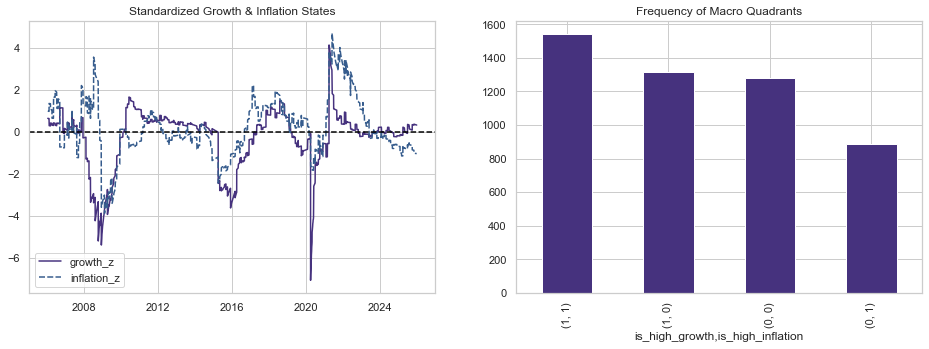

In [38]:
def engineer_state_features(df):
    """
    Transforms raw levels into standardized state indicators.
    """
    states = pd.DataFrame(index=df.index)
    
    # 1. Growth Proxy (Industrial Production YoY)
    states['growth_z'] = (df['INDPRO'].pct_change(252) - df['INDPRO'].pct_change(252).rolling(1260).mean()) / df['INDPRO'].pct_change(252).rolling(1260).std()
    
    # 2. Inflation Proxy (CPI YoY)
    states['inflation_z'] = (df['CPIAUCSL'].pct_change(252) - df['CPIAUCSL'].pct_change(252).rolling(1260).mean()) / df['CPIAUCSL'].pct_change(252).rolling(1260).std()
    
    # 3. Monetary Tightness (Fed Funds vs 10Y Yield)
    states['yield_curve'] = df['DGS10'] - df['FEDFUNDS']
    
    # 4. Sentiment (Michigan Consumer Sentiment standardized)
    states['sentiment_z'] = (df['UMCSENT'] - df['UMCSENT'].rolling(1260).mean()) / df['UMCSENT'].rolling(1260).std()
    
    # Define Quadrants (Binary Filters)
    states['is_high_growth'] = (states['growth_z'] > 0).astype(int)
    states['is_high_inflation'] = (states['inflation_z'] > 0).astype(int)
    
    return states.dropna()

macro_states = engineer_state_features(macro_raw)

fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.lineplot(data=macro_states[['growth_z', 'inflation_z']], ax=ax[0])
ax[0].set_title("Standardized Growth & Inflation States")
ax[0].axhline(0, color='black', linestyle='--')

macro_states[['is_high_growth', 'is_high_inflation']].value_counts().plot(kind='bar', ax=ax[1])
ax[1].set_title("Frequency of Macro Quadrants")
plt.show()

**Shocks & Information Catalysts**

**Statistical Rationale**
- To build predictive signals, we will be converting non-stationary macro levels into **stationary innovations**. We will define a "Macro Shock" as the daily innovation normalized by its rolling standard deviation. This allows us to compare the relative impact of a VIX spike vs a Fed Funds move on the same scale.

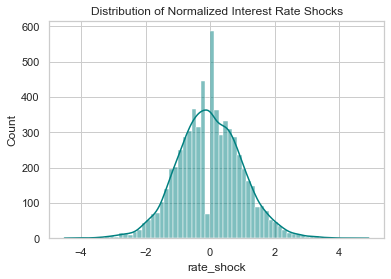

In [39]:
def engineer_shock_features(df):
    """
    Constructs volatility-normalized shocks for market-moving variables.
    """
    shocks = pd.DataFrame(index=df.index)
    
    # Interest Rate Shocks
    shocks['rate_shock'] = df['DGS10'].diff() / df['DGS10'].diff().rolling(60).std()
    
    # Energy Shocks (Log returns normalized)
    shocks['energy_shock'] = np.log(df['DCOILWTICO']).diff() / np.log(df['DCOILWTICO']).diff().rolling(60).std()
    
    # Volatility Shocks (VIX levels change normalized)
    shocks['vol_shock'] = df['VIXCLS'].diff() / df['VIXCLS'].diff().rolling(60).std()
    
    return shocks.dropna()

macro_shocks = engineer_shock_features(macro_raw)
sns.histplot(macro_shocks['rate_shock'], kde=True, color='teal')
plt.title("Distribution of Normalized Interest Rate Shocks")
plt.show()

**Macro-Financial Sensitivity (Dynamic Linkages)**

**Question?**
- How does the linkage between equities (SPY) and commodities (GLD) shift across macro states? We use rolling correlations weighted by macro shocks to identify periods of **regime decoupling**.

In [ ]:
# Calculate returns
returns = np.log(prices_raw).diff().dropna()

# Rolling Correlation: Equities vs Commodities (6-month window approx 126 days)
rolling_corr = returns['SPY'].rolling(126).corr(returns['GLD']).dropna()

# Align macro states to match the correlation index for plotting
infl_filter = macro_states['is_high_inflation'].reindex(rolling_corr.index).fillna(0)

plt.figure(figsize=(14, 6))
plt.plot(rolling_corr, label='SPY-GLD 6M Rolling Correlation', color='darkblue')
plt.fill_between(rolling_corr.index, 0, 1, where=(infl_filter == 1), 
                 color='red', alpha=0.1, label='High Inflation Regime')
plt.title("Asset Correlation Dynamics across Inflationary Regimes")
plt.legend()
plt.show()

**Integrated Feature Export**

Finally, we will consolidate our engineered states and shocks into a single master feature file for subsequent Markov-Switching modeling.

In [ ]:
final_features = pd.concat([macro_states, macro_shocks], axis=1).dropna()
output_path = "../data/processed/integrated_features.csv"
if not os.path.exists("../data/processed"):
    output_path = "data/processed/integrated_features.csv"

final_features.to_csv(output_path)
print(f"Success: {final_features.shape[0]} samples exported to {output_path}")
final_features.tail()